# Creating Temporal Visualization of Sentiment

* Loading cleaned dataframe into dask in order to create temporal graphs

In [4]:
! pip install graphviz

In [5]:
from dask_yarn import YarnCluster
from dask.distributed import Client

In [6]:
import pickle
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
import pandas as pd
import time

# NOTE: stopwords include pronouns! TODO: make custom stop words list?
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hadoop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Create a cluster where each worker has 1 cores and 4 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "4GiB"
                      )

# Scale cluster out to 8 such workers:
cluster.scale(8)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.30.12:40661
distributed.scheduler - INFO -   dashboard at:                    :42681
distributed.scheduler - INFO - Receive client connection: Client-52c87230-c635-11eb-8fdd-0a4303b57183
distributed.core - INFO - Starting established connection


In [15]:
client

Client Scheduler: tcp://172.31.30.12:40661 Dashboard: /proxy/42681/status,Cluster Workers: 5 Cores: 5 Memory: 20.00 GiB


In [26]:
comments_corpus = pickle.load(open("reddit_comments_with_sentiment.pickle","rb"))

distributed.utils_perf - INFO - full garbage collection released 1.26 GiB from 7058 reference cycles (threshold: 9.54 MiB)


In [27]:
import dask.dataframe as ddf
comments_corpus = ddf.from_pandas(comments_corpus, npartitions=12)

distributed.core - INFO - Event loop was unresponsive in Scheduler for 5.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [29]:
comments_corpus = comments_corpus.compute()

distributed.core - INFO - Event loop was unresponsive in Scheduler for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - INFO - full garbage collection released 1.27 GiB from 478 reference cycles (threshold: 9.54 MiB)


/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


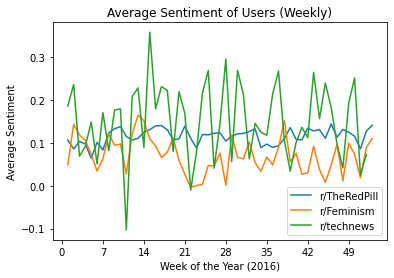

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

pill = comments_corpus.loc[comments_corpus['subreddit'] == 'TheRedPill']
fem = comments_corpus.loc[comments_corpus['subreddit'] == 'Feminism']
tech = comments_corpus.loc[comments_corpus['subreddit'] == 'technews']

#[air_quality["datetime"].dt.weekday, "location"]
monthly_pill = pill.groupby(pill['time created'].dt.weekofyear).mean()['compound']
monthly_fem = fem.groupby(fem['time created'].dt.weekofyear).mean()['compound']
monthly_tech = tech.groupby(tech['time created'].dt.weekofyear).mean()['compound']
plt.plot(monthly_pill, label = "r/TheRedPill")
plt.plot(monthly_fem, label = "r/Feminism")
plt.plot(monthly_tech, label = "r/technews")

plt.xticks(np.arange(0, 52 , 7.0))
plt.title('Average Sentiment of Users (Weekly)')
plt.xlabel('Week of the Year (2016)')
plt.ylabel('Average Sentiment')
plt.legend()
plt.show()